In [1]:
# from google.colab import drive

# drive.mount('/content/gdrive')


# %cd gdrive/My\ Drive/Chinese-LSTM/code

In [2]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import json

from typing import Tuple, List, Dict
import tensorflow.keras as K
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from sklearn.preprocessing import OneHotEncoder

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.random import set_random_seed
set_random_seed(42)
from createdataset import *

In [21]:
SUBSET = ['pku','msr']
PADDING_SIZE = 30
data, uni_word_to_idx, bi_word_to_idx = data_feed(SUBSET, PADDING_SIZE)

# saving critical info to be later used when used on test sets
predict_dict = dict()
predict_dict.update({"PADDING_SIZE": PADDING_SIZE})
predict_dict.update({"UNIGRAM_DICT": uni_word_to_idx})
predict_dict.update({"BIGRAM_DICT": bi_word_to_idx})

rel_path = '../resources/vocabs/'
if not os.path.exists(rel_path):
    os.mkdir(rel_path)
with open(rel_path + '_'.join(SUBSET) + "_" + str(PADDING_SIZE) + '.json', 'w') as f:
    json.dump(predict_dict, f)

*****training*****
creating file
creating file
X uni-bi shape: (105980, 30)(105980, 30)
y shape: (105980, 30, 4)
creating file
creating file
*****dev*****
X uni-bi shape: (5930, 30)(5930, 30)
y shape: (5930, 30, 4)


# model

In [38]:
VOCAB_SIZE = {"unigrams": data['train']['info']['uni_VocabSize'],
              "bigrams": data['train']['info']['bi_VocabSize']}
EMBEDDING_SIZE = {"unigrams": 64,
                  "bigrams": 16}
HIDDEN_SIZE = 256
batch_size = 128
epochs = 20
LEARNING_RATE = 0.0015
INPUT_DROPOUT = 0.2
LSTM_DROPOUT = 0.45
RECURRENT_DROPOUT = 0.35

In [39]:
K.backend.clear_session()

In [40]:
model_name = time.strftime('%Y-%m-%d_%H:%M:%S_%z')
def Model_A(vocab_size, embedding_size, hidden_size, PADDING_SIZE, LEARNING_RATE, INPUT_DROPOUT, LSTM_DROPOUT, RECURRENT_DROPOUT):
    print("Creating KERAS model")
    
    unigrams = K.layers.Input(shape=(None,))
    embedding_unigrams = K.layers.Embedding(vocab_size["unigrams"],
                                            embedding_size['unigrams'],
                                            mask_zero=True,
                                            name = 'embedding_unigrams')(unigrams)
    
    bigrams = K.layers.Input(shape=(None,))
    embedding_bigrams = K.layers.Embedding(vocab_size["bigrams"],
                                           embedding_size['bigrams'],
                                           mask_zero=True,
                                           name = 'embedding_bigrams')(bigrams)

    merged_vector = K.layers.concatenate([embedding_unigrams, embedding_bigrams], axis=-1, name = 'concatenated')
    
    BI_LSTM = (K.layers.Bidirectional(
               K.layers.LSTM(hidden_size, dropout = LSTM_DROPOUT,
                             recurrent_dropout = RECURRENT_DROPOUT,
                             return_sequences=True,
                             kernel_regularizer=K.regularizers.l2(0.01),
                             activity_regularizer=K.regularizers.l1(0.01)
                            ),name = 'Bi-directional_LSTM'))(merged_vector)
    
    predictions = K.layers.TimeDistributed(K.layers.Dense(4, activation='softmax'))(BI_LSTM)
    
    model = K.models.Model(inputs=[unigrams, bigrams], outputs=predictions) 
    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = K.optimizers.Adam(lr=LEARNING_RATE, clipnorm=1., clipvalue=0.5),
                  metrics = ['acc', K.metrics.Precision()])

    return model

model = Model_A(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE,
                PADDING_SIZE, LEARNING_RATE, INPUT_DROPOUT,
                LSTM_DROPOUT, RECURRENT_DROPOUT)
# Let's print a summary of the model
model.summary()
  


Creating KERAS model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_unigrams (Embedding)  (None, None, 64)     343616      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_bigrams (Embedding)   (None, None, 16)     8430688     input_2[0][0]                    
________________________________________________________________________________________

In [41]:
if not os.path.exists('../resources/report_images'):
    os.mkdir('../resources/report_images')

cbk = K.callbacks.TensorBoard('../resources/logging/keras_model_'+model_name)
print("\nStarting training...")
K.utils.plot_model(model, to_file='../resources/report_images/model.png')


Starting training...


In [42]:
early_stopping = K.callbacks.EarlyStopping(monitor='val_precision',
                              min_delta=0,
                              patience=3,
                              verbose=2, mode='auto')
csv_logger = K.callbacks.CSVLogger('../resources/logging/keras_model_'+model_name+'.log')
model_checkpoint = K.callbacks.ModelCheckpoint(filepath = '../resources/logging/keras_model_'+model_name+'.h5',
                                               monitor='val_precision',
                                               verbose=2,
                                               save_best_only=True,
                                               save_weights_only=True,
                                               mode='auto', period=1)

In [ ]:

model.fit(data["train"]["X"], data["train"]["y"],
          epochs=epochs, batch_size=batch_size, shuffle=True,
          validation_data=(data["dev"]["X"], data["dev"]["y"]),
          callbacks=[cbk, csv_logger, model_checkpoint, early_stopping]) 
print("Training complete.\n")



Train on 105980 samples, validate on 5930 samples
Epoch 1/20
 61056/105980 [================>.............] - ETA: 3:44 - loss: 0.6434 - acc: 0.7929 - precision: 0.9026

In [30]:
rel_path = '../resources/models'
if not os.path.exists(rel_path):
    os.mkdir(rel_path)
weights = os.path.join(rel_path,'model_weights_'+model_name+'_'.join(SUBSET)+'.h5')
model_name_save = os.path.join(rel_path,'model_'+model_name+'_'.join(SUBSET)+'.h5')
model.save_weights(weights) #saving weights for further analysis
model.save(model_name_save)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


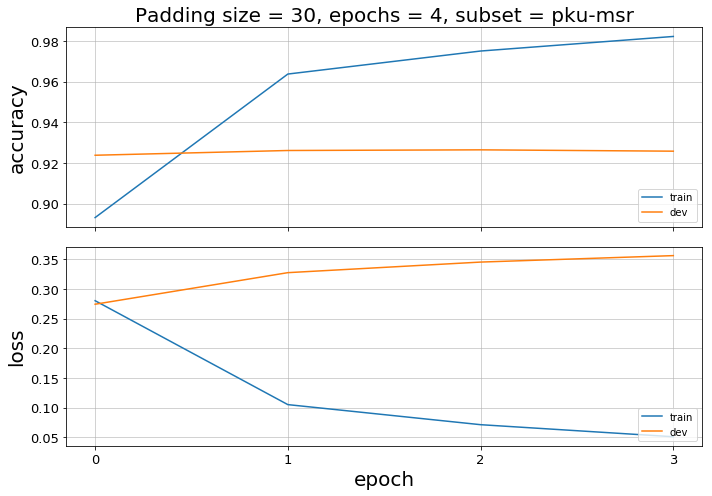

In [33]:
def plot_training(model_name, save = False, PADDING_SIZE = None, epochs = None, subset = None, size = 30):
    if not model_name:
        selected = False
        while not selected:
            c=0
            for ind, i in enumerate(os.listdir("../resources/logging")):
                print("{}:\t{}".format(ind, i))
            x = int(input("Please select one of the above with a numer: "))
            model_name = os.listdir("../resources/logging")[x]
            if model_name.endswith(".log"):
                selected = True
            else: 
                print("please select a correct log file to load")
        history = pd.read_csv('../resources/logging/'+model_name)
        #PADDING_SIZE, epochs, subset = 'Unknown', history.shape[0], 'Unknown'
    else:
        history = pd.read_csv('../resources/logging/keras_model_'+model_name+'.log')
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7))
    # summarize history for accuracy
    axs[0].plot(history['acc'])
    axs[0].plot(history['val_acc'])
    #axs[0].title('model accuracy')
    axs[0].set_ylabel('accuracy',size = size)
    #axs[0].set_xlabel('epoch')
    axs[0].set_xticks((list(range(0,epochs))))
    axs[0].legend(['train', 'dev'], loc='lower right')
    axs[0].grid(alpha=0.7)

    axs[0].set_title("Padding size = {}, epochs = {}, subset = {}".format(PADDING_SIZE, epochs, subset), size = size)
    
    axs[0].tick_params(axis='x', labelsize=int(size/1.5))
    axs[1].tick_params(axis='x', labelsize=int(size/1.5))
    axs[0].tick_params(axis='y', labelsize=int(size/1.5))
    axs[1].tick_params(axis='y', labelsize=int(size/1.5))
    
    # summarize history for loss
    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].set_ylabel('loss', size = size)
    axs[1].set_xlabel('epoch', size = size)
    axs[1].set_xticks((list(range(0,epochs))))
    axs[1].legend(['train', 'dev'], loc='lower right')
    axs[1].grid(alpha=0.7)
    fig.show()
    fig.tight_layout()
    fig.subplots_adjust(wspace=1, hspace=0.1)
    if save:
        fig.savefig("../resources/report_images/"+model_name+"training_plot.png")
plot_training(model_name, True, PADDING_SIZE, 4, '-'.join(SUBSET), size = 20)

In [34]:
history = pd.read_csv('../resources/logging/keras_model_'+model_name+'.log') = pd.read_csv('../resources/logging/keras_model_'+model_name+'.log')

In [35]:
history

,epoch,acc,loss,precision,val_acc,val_loss,val_precision
0,0,0.893084,0.279971,0.931390,0.923749,0.274034,0.926350
1,1,0.963692,0.104964,0.965775,0.926087,0.327213,0.927679
2,2,0.975015,0.071169,0.976017,0.926409,0.345030,0.927580
3,3,0.982185,0.050860,0.982761,0.925751,0.355912,0.926537
